In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from utils import get_clf_report_dfs, plot_confusion_matrix

In [2]:
RANDOM_SEED=42
RESULTS_DIR="./results"
MODEL_NAME="deepCNN"
np.random.seed(RANDOM_SEED)
tf.keras.utils.set_random_seed(RANDOM_SEED)

In [3]:
data = np.load('./dataset/dataset.npz')
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']
y_mapping = data['y_mapping']

In [ ]:
class deepCNN:
    def __init__(self, input_shape, num_classes, learning_rate=1e-4):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.learning_rate = learning_rate
    
    def double_conv(self, filters):
        return tf.keras.Sequential([
            tf.keras.layers.Conv1D(filters, 3, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv1D(filters, 3, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
        ])

    def build(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Input(shape=self.input_shape))

        model.add(self.double_conv(64))
        model.add(tf.keras.layers.MaxPooling1D(2))

        model.add(self.double_conv(128))
        model.add(tf.keras.layers.MaxPooling1D(2))

        model.add(self.double_conv(256))
        model.add(tf.keras.layers.MaxPooling1D(2))

        model.add(self.double_conv(512))
        model.add(tf.keras.layers.MaxPooling1D(2))

        model.add(self.double_conv(1024))
        model.add(tf.keras.layers.GlobalAveragePooling1D())

        model.add(tf.keras.layers.Dense(self.num_classes, activation='softmax'))

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )
        
        return model


In [7]:
num_epochs = 500
batch_size = 16
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10)

model = deepCNN(
    input_shape=X_train.shape[1:],
    num_classes=y_train.shape[0],
).build()

history = model.fit(
    X_train, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[
        early_stopping,
        lr_scheduler
    ],
    verbose=1
)
model.save(os.path.join(RESULTS_DIR, f"{MODEL_NAME}.keras"))

Epoch 1/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 4.7937 - sparse_categorical_accuracy: 0.2200 - val_loss: 5.9704 - val_sparse_categorical_accuracy: 0.0519 - learning_rate: 1.0000e-04
Epoch 2/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 1.2983 - sparse_categorical_accuracy: 0.7302 - val_loss: 5.4626 - val_sparse_categorical_accuracy: 0.0519 - learning_rate: 1.0000e-04
Epoch 3/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.6489 - sparse_categorical_accuracy: 0.8316 - val_loss: 5.1730 - val_sparse_categorical_accuracy: 0.0519 - learning_rate: 1.0000e-04
Epoch 4/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.3307 - sparse_categorical_accuracy: 0.9489 - val_loss: 4.9923 - val_sparse_categorical_accuracy: 0.0519 - learning_rate: 1.0000e-04
Epoch 5/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.1730 - sparse_categorical_accuracy: 0.9902 - val_loss: 4.8708 - val_sparse_categorical_accuracy: 0.0649 - learning_rate: 1.0000e-04
Epoch 6/500
39/39 ━━━━━━━━━━━━

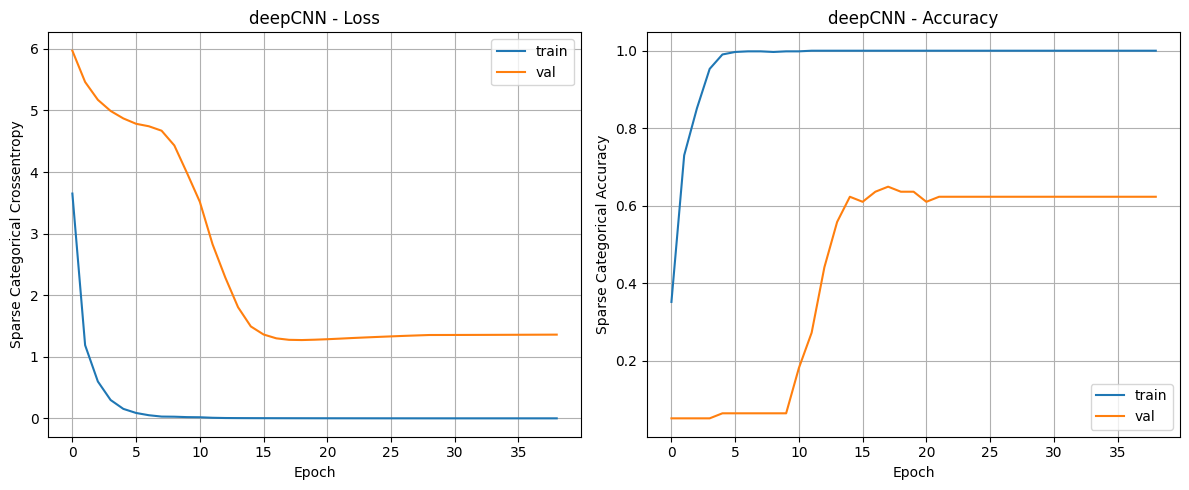

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history["loss"], label="train")
ax1.plot(history.history["val_loss"], label="val")
ax1.set_title(f"{MODEL_NAME} - Loss")
ax1.set_ylabel("Sparse Categorical Crossentropy")
ax1.set_xlabel("Epoch")
ax1.grid()
ax1.legend()

ax2.plot(history.history["sparse_categorical_accuracy"], label="train")
ax2.plot(history.history["val_sparse_categorical_accuracy"], label="val")
ax2.set_title(f"{MODEL_NAME} - Accuracy")
ax2.set_ylabel("Sparse Categorical Accuracy")
ax2.set_xlabel("Epoch")
ax2.grid()
ax2.legend()

fig.tight_layout()

In [9]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
val_loss, val_accuracy = model.evaluate(X_val, y_val)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "Loss": [train_loss, test_loss],
    "Accuracy": [train_accuracy, test_accuracy]
}).set_index("Dataset")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0859 - sparse_categorical_accuracy: 0.9693
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2100 - sparse_categorical_accuracy: 0.6463
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1919 - sparse_categorical_accuracy: 0.6561


,Loss,Accuracy
Dataset,,
Train,0.080542,0.977383
Test,1.157762,0.679487


In [10]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

np.save(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_predictions.npy"), y_pred)

y_test_str = [y_mapping[label] for label in y_test]
y_pred_str = [y_mapping[label] for label in y_pred]

clf_scores_df, per_class_clf_scores_df = get_clf_report_dfs(
    y_true=y_test_str, y_pred=y_pred_str,
    clf_scores_path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_clf_scores.csv"),
    clf_per_class_scores_path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_per_class_clf_scores.csv")
)

clf_scores_df

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


,accuracy,f1-score macro avg,f1-score weighted avg,precision macro avg,precision weighted avg,recall macro avg,recall weighted avg
0,0.679487,0.679627,0.667125,0.7187,0.716982,0.701042,0.679487


In [11]:
per_class_clf_scores_df.style.background_gradient(cmap="Blues")

,precision,recall,f1-score,support
ball,0.500000,1.000000,0.666667,4.000000
bigball,0.600000,0.600000,0.600000,5.000000
box,0.833333,1.000000,0.909091,5.000000
button,0.500000,0.166667,0.250000,6.000000
case,0.800000,0.800000,0.800000,5.000000
cube,0.750000,0.600000,0.666667,5.000000
cylinder,0.600000,0.600000,0.600000,5.000000
jenga,0.666667,0.400000,0.500000,5.000000
labello,0.833333,1.000000,0.909091,5.000000
lemon,0.400000,0.400000,0.400000,5.000000


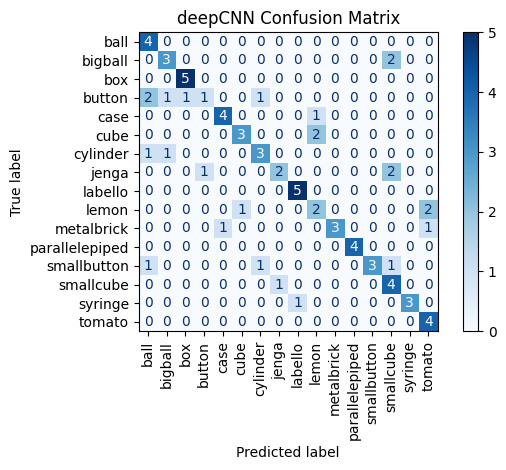

In [12]:
plot_confusion_matrix(
    y_true=y_test_str,
    y_pred=y_pred_str,
    title=f"{MODEL_NAME} Confusion Matrix",
    path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_confusion_matrix.png")
)